Mounting Google Drive for dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing pyspark and importing modules

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285397 sha256=08a134825558327722d47d399e4d85477a2a1605305b69ffd1b3d3522d3c02d9
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, desc , col, max, struct
import matplotlib.pyplot as plts
from pyspark.ml.feature import  StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder


In [ ]:
spark = SparkSession.builder.appName('MusicRec').getOrCreate()

In [ ]:
listening_csv_path = '/content/drive/My Drive/dataset/listenings.csv'
listening_data_frame = spark.read.format('csv').option('inferSchema', True).option('header', True).load(listening_csv_path)

In [ ]:
listening_data_frame.show()

+-----------+-------------+--------------------+---------------+--------------------+
|    user_id|         date|               track|         artist|               album|
+-----------+-------------+--------------------+---------------+--------------------+
|000Silenced|1299680100000|           Price Tag|       Jessie J|         Who You Are|
|000Silenced|1299679920000|Price Tag (Acoust...|       Jessie J|           Price Tag|
|000Silenced|1299679440000|Be Mine! (Ballad ...|          Robyn|            Be Mine!|
|000Silenced|1299679200000|            Acapella|          Kelis|            Acapella|
|000Silenced|1299675660000|   I'm Not Invisible|      The Tease|   I'm Not Invisible|
|000Silenced|1297511400000|Bounce (Feat NORE...|       MSTRKRFT|         Fist of God|
|000Silenced|1294498440000|Don't Stop The Mu...|        Rihanna|Addicted 2 Bassli...|
|000Silenced|1292438340000|               ObZen|      Meshuggah|               ObZen|
|000Silenced|1292437740000|   Yama's Messengers|      

Dropping date column as it is not required

In [ ]:
listening_data_frame = listening_data_frame.drop('date')

In [ ]:
listening_data_frame = listening_data_frame.na.drop()

In [ ]:
listening_data_frame.show()

+-----------+--------------------+---------------+--------------------+
|    user_id|               track|         artist|               album|
+-----------+--------------------+---------------+--------------------+
|000Silenced|           Price Tag|       Jessie J|         Who You Are|
|000Silenced|Price Tag (Acoust...|       Jessie J|           Price Tag|
|000Silenced|Be Mine! (Ballad ...|          Robyn|            Be Mine!|
|000Silenced|            Acapella|          Kelis|            Acapella|
|000Silenced|   I'm Not Invisible|      The Tease|   I'm Not Invisible|
|000Silenced|Bounce (Feat NORE...|       MSTRKRFT|         Fist of God|
|000Silenced|Don't Stop The Mu...|        Rihanna|Addicted 2 Bassli...|
|000Silenced|               ObZen|      Meshuggah|               ObZen|
|000Silenced|   Yama's Messengers|         Gojira|The Way of All Flesh|
|000Silenced|On the Brink of E...|   Napalm Death|Time Waits For No...|
|000Silenced|On the Brink of E...|   Napalm Death|Time Waits For

In [ ]:
listening_data_frame.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- track: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- album: string (nullable = true)



In [ ]:
rows = listening_data_frame.count()
cols = len(listening_data_frame.columns)
print(rows,cols)

13758905 4


**Top** 10 Tracks

In [ ]:
query1 = listening_data_frame.select('artist', 'track').groupby('artist', 'track').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)
query1.show()

+--------------+----------------+-----+
|        artist|           track|count|
+--------------+----------------+-----+
| Justin Bieber|           Sorry| 3381|
|Arctic Monkeys|Do I Wanna Know?| 2865|
|      Bon Iver|     Skinny Love| 2836|
|          Zayn|      PILLOWTALK| 2701|
|   The Killers|   Mr Brightside| 2690|
|       Rihanna|            Work| 2646|
|      Bastille|         Pompeii| 2606|
|Mumford & Sons| Little Lion Man| 2520|
|Mumford & Sons|        The Cave| 2485|
| Justin Bieber|   Love Yourself| 2481|
+--------------+----------------+-----+



Top 10 fans of Eminem

In [ ]:
query2 = listening_data_frame.select('user_id').filter(listening_data_frame.artist == 'Eminem').groupby('user_id').agg(count('user_id').alias('count')).orderBy(desc('count')).limit(10)
query2.show()

+-------------+-----+
|      user_id|count|
+-------------+-----+
|   joeyjoefro|  188|
|DanceHallDays|  176|
| andytrickett|  164|
|    SlimNeddy|  162|
| saralawtonxX|  147|
|     megalolz|  114|
|Melbourne1992|  110|
|   flintshine|  108|
|        jjk89|  106|
|      craig92|  104|
+-------------+-----+



Top artists and albums based on the number of times they have been listened to

In [ ]:
query3 = listening_data_frame.select('artist', 'album').groupby('artist', 'album').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)
query3.show()

+--------------------+--------------------+-----+
|              artist|               album|count|
+--------------------+--------------------+-----+
|          Kanye West|   The Life Of Pablo|22310|
|              The xx|                  xx|14195|
|      Arctic Monkeys|                  AM|14090|
|               alt-J|     An Awesome Wave|13635|
|      Mumford & Sons|        Sigh No More|13543|
|      Arctic Monkeys|Whatever People S...|12731|
|            Bon Iver|            For Emma|11994|
|              Grimes|          Art Angels|11655|
|Florence + the Ma...|               Lungs|11362|
|               Adele|                  21|11215|
+--------------------+--------------------+-----+



Importing and merging genre.csv

In [ ]:
genre_csv_path = '/content/drive/My Drive/dataset/genre.csv'
genre_data_frame = spark.read.format('csv').option('inferSchema', True).option('header', True).load(genre_csv_path)
data = listening_data_frame.join(genre_data_frame, how='inner', on=['artist'])
data.show()

+------------+-----------+--------------------+--------------------+--------------------+
|      artist|    user_id|               track|               album|               genre|
+------------+-----------+--------------------+--------------------+--------------------+
|    Jessie J|000Silenced|           Price Tag|         Who You Are| Ariana Grande & ...|
|    Jessie J|000Silenced|           Price Tag|         Who You Are| Jhene Aiko & Rixton|
|    Jessie J|000Silenced|           Price Tag|         Who You Are| Nicki Minaj & Ar...|
|    Jessie J|000Silenced|           Price Tag|         Who You Are|                 pop|
|    Jessie J|000Silenced|Price Tag (Acoust...|           Price Tag| Ariana Grande & ...|
|    Jessie J|000Silenced|Price Tag (Acoust...|           Price Tag| Jhene Aiko & Rixton|
|    Jessie J|000Silenced|Price Tag (Acoust...|           Price Tag| Nicki Minaj & Ar...|
|    Jessie J|000Silenced|Price Tag (Acoust...|           Price Tag|                 pop|
|       Ro

Top 10 music Genres

In [ ]:
query4 = data.select('genre').groupby('genre').agg(count('genre').alias('count')).orderBy(desc('count')).limit(10)
query4.show()

+----------+-------+
|     genre|  count|
+----------+-------+
|      rock|2691934|
|       pop|1544747|
|electronic| 551509|
|   hip hop| 532984|
|      folk| 438174|
|indie rock| 431439|
|      punk| 380915|
|       r&b| 344101|
|     metal| 208107|
|     indie| 206726|
+----------+-------+



Top 10 listeners of Metal music

In [ ]:
query5 = data.select('user_id').where(data.genre == 'pop').groupby('user_id').agg(count('user_id').alias('count')).orderBy(desc('count')).limit(10)
query5.show()

+---------------+-----+
|        user_id|count|
+---------------+-----+
|        01Green|  496|
|      momousagi|  400|
|          mrpsb|  400|
|   BlueKnockOut|  378|
|    musicboy80s|  376|
|  incultojurgis|  374|
| ElektricOrchid|  370|
|foreign_fanatic|  350|
|   Kevin_Soutar|  346|
|  landrover2171|  301|
+---------------+-----+



Graph showing number of artists for each Genre

Text(0.5, 1.0, 'Genre Distribution')

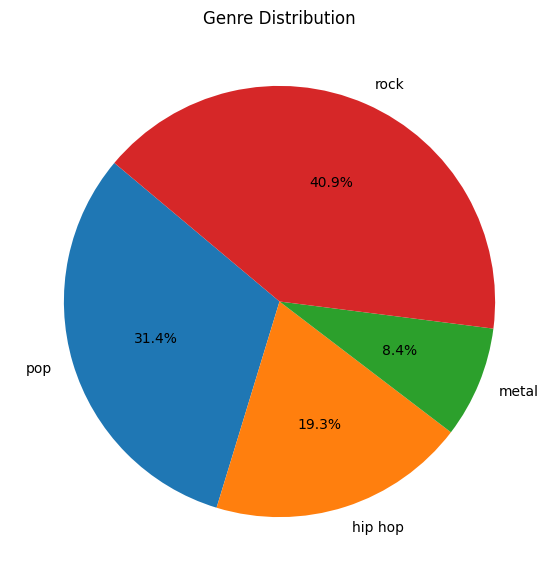

In [ ]:
query6 = genre_data_frame.select('genre').where((col('genre')=='pop') | (col('genre')=='rock') | (col('genre')=='metal') | (col('genre')=='hip hop')).groupby('genre').agg(count('genre').alias('count'))
query6_graph = query6.collect()
labels = [row['genre'] for row in query6_graph]
counts = [row['count'] for row in query6_graph]
plts.figure(figsize=(7, 7))
plts.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
plts.title('Genre Distribution')


Recommendation System

In [ ]:
listening_csv_path_ml = '/content/drive/My Drive/dataset/listenings.csv'
listening_ml = spark.read.format('csv').option('inferSchema', True).option('header', True).load(listening_csv_path_ml)
listening_ml = listening_ml.drop('date')
listening_ml = listening_ml.na.drop()


Finding out how many times a user listened to a specific song

In [ ]:
listening_ml_agg = listening_ml.select('user_id', 'track').groupby('user_id', 'track').agg(count('*').alias('count')).orderBy('user_id')
listening_ml_agg.show()

+-------+--------------------+-----+
|user_id|               track|count|
+-------+--------------------+-----+
| --Seph| White Winter Hymnal|    3|
| --Seph|         The Funeral|    1|
| --Seph|Hope There's Someone|    1|
| --Seph|         The Painter|    1|
| --Seph|          Je te veux|    1|
| --Seph|            War Pigs|    1|
| --Seph|                 F12|    1|
| --Seph|                Team|    1|
| --Seph|          Nightmares|    1|
| --Seph|               Radio|    1|
| --Seph|   All I Want Is You|    1|
| --Seph|    Little by Little|    2|
| --Seph|        After Nature|    1|
| --Seph|In the Hall of th...|    1|
| --Seph|   Hey There Delilah|    1|
| --Seph|   Let's Call It Off|    1|
| --Seph|               Leloo|    1|
| --Seph|             Pack Up|    1|
| --Seph|           Introitus|    1|
| --Seph|        The Leanover|    1|
+-------+--------------------+-----+
only showing top 20 rows



Total number of rows and columns in the dataframe now

In [ ]:
row = listening_ml_agg.count()
col = len(listening_ml_agg.columns)
print(row,col)

9930128 3


Limiting the rows for faster processing

In [ ]:
listening_ml_agg = listening_ml_agg.limit(30000)

StringIndexer, pipeline model and transform performed

In [ ]:
strindexer = [StringIndexer(inputCol = col, outputCol = col + '_index').fit(listening_ml_agg) for col in list(set(listening_ml_agg.columns)- set(['count']))]
indexer = [new_strindexer.setHandleInvalid("keep") for new_strindexer in strindexer]
pipeline = Pipeline(stages = indexer)
data_ml = pipeline.fit(listening_ml_agg).transform(listening_ml_agg)
data_ml.show()


+-------+--------------------+-----+-----------+-------------+
|user_id|               track|count|track_index|user_id_index|
+-------+--------------------+-----+-----------+-------------+
| --Seph|          Nightmares|    1|     2373.0|        104.0|
| --Seph|             Starman|    2|      938.0|        104.0|
| --Seph|     Gnossienne No 3|    1|    10086.0|        104.0|
| --Seph|       Pressure Drop|    1|     2527.0|        104.0|
| --Seph|         Agoraphobia|    1|     1128.0|        104.0|
| --Seph|Belina (Original ...|    1|     5319.0|        104.0|
| --Seph|The Windmills Of ...|    1|    21505.0|        104.0|
| --Seph|Hungarian Dance No 5|    1|    11220.0|        104.0|
| --Seph|Airplanes [feat H...|    1|     1133.0|        104.0|
| --Seph|  California Waiting|    1|      517.0|        104.0|
| --Seph|   Needle in the Hay|    1|    15309.0|        104.0|
| --Seph|   Summa for Strings|    1|    19826.0|        104.0|
| --Seph|     Everyday People|    1|     1658.0|       

In [ ]:
data_ml = data_ml.select('user_id_index', 'track_index', 'count').orderBy('user_id_index')
data_ml.show()

+-------------+-----------+-----+
|user_id_index|track_index|count|
+-------------+-----------+-----+
|          0.0|    15533.0|    1|
|          0.0|     5395.0|    1|
|          0.0|    17641.0|    1|
|          0.0|    16920.0|    2|
|          0.0|    14770.0|    4|
|          0.0|      953.0|    1|
|          0.0|    24093.0|    1|
|          0.0|    17037.0|    1|
|          0.0|    21628.0|    1|
|          0.0|     2465.0|    1|
|          0.0|     8870.0|    1|
|          0.0|    16292.0|    1|
|          0.0|     4057.0|    2|
|          0.0|    20604.0|    1|
|          0.0|     8134.0|    1|
|          0.0|    16304.0|    1|
|          0.0|     3874.0|    1|
|          0.0|     4730.0|    1|
|          0.0|     4461.0|    4|
|          0.0|     9139.0|    1|
+-------------+-----------+-----+
only showing top 20 rows



Train and Test data

In [ ]:
(training, test) = data_ml.randomSplit([0.5,0.5])


In [ ]:
USERID = "user_id_index"
TRACK = "track_index"
COUNT = "count"

als = ALS(maxIter = 5, regParam = 0.01, userCol = USERID, itemCol = TRACK, ratingCol = COUNT)
model = als.fit(training)
predictions = model.transform(test)

View recommendations

In [ ]:
recs = model.recommendForAllUsers(10)
recs.show()

+-------------+--------------------+
|user_id_index|     recommendations|
+-------------+--------------------+
|            0|[{11973, 14.01359...|
|            1|[{715, 13.951651}...|
|            2|[{24141, 14.15011...|
|            3|[{706, 9.683796},...|
|            4|[{1020, 9.103763}...|
|            5|[{706, 19.353054}...|
|            6|[{11973, 15.02662...|
|            7|[{559, 15.254009}...|
|            8|[{11973, 11.56950...|
|            9|[{15550, 6.996308...|
|           10|[{3, 9.049439}, {...|
|           11|[{24141, 9.20388}...|
|           12|[{798, 7.1905756}...|
|           13|[{1020, 10.861052...|
|           14|[{22128, 7.077250...|
|           15|[{15550, 10.70457...|
|           16|[{715, 12.650956}...|
|           17|[{12072, 4.672585...|
|           18|[{6408, 8.410766}...|
|           19|[{15550, 8.281066...|
+-------------+--------------------+
only showing top 20 rows



Lets look at first result

In [ ]:
recs.take(1)

[Row(user_id_index=0, recommendations=[Row(track_index=11973, rating=14.013596534729004), Row(track_index=706, rating=10.545039176940918), Row(track_index=351, rating=10.498135566711426), Row(track_index=715, rating=10.282034873962402), Row(track_index=559, rating=10.136338233947754), Row(track_index=3082, rating=10.087836265563965), Row(track_index=20590, rating=9.1870698928833), Row(track_index=273, rating=8.86929702758789), Row(track_index=22096, rating=8.505060195922852), Row(track_index=8067, rating=8.011882781982422)])]